# Head Pose Estimator

Tatsuya J. Arai @araitats, Sunil Mallya @smallya
02/01/2018


## Introduction

In this notebook, the details of construction of convolutional neural network based head pose estimator are described. 

## Overview 

When there is a face photo presented in front of you, your human eyes can immediately recognize what direction the person in the photo is looking at (e.g. either facing straight up to the camera or looking at somewhere else).  The direction is defined as the head pose. A convolutional neural network model is trained with thousands of such face photos and their corresponding head pose labels, the model will be able to estimate various head poses when a new batch of face images are presented. In this notebook, the head pose is categorized into nine classes (i.e. the combinations of looking down, straight, and up (tilt angles) and looking right, middle and left (pan angles)).
    
## Modules

In [1]:
import os
import sys
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import mxnet as mx
## Python version
print(sys.version)

2.7.12 (default, Nov 20 2017, 18:23:56) 
[GCC 5.4.0 20160609]


2.7.12 (default, Nov 20 2017, 18:23:56)  [GCC 5.4.0 20160609]

In [3]:
print(mx.__version__)

0.11.0


0.11.0

## Helper functions

### EvalCallback  

``EvalCallback`` class is to keep track and save the best model found during the training based on the metric you specified.  

In [4]:
class EvalCallback(object):
    '''
    Attempt at a Earlystopping solution using the first metric.
    
    pass an instance of the metric or the instance name to specify which metric to use for stopping
    
    1. epoch_end_callback: doesn't provide the metrics to the registered callback function, hence we can't use it to track
    metrics and save
    
    2. eval_batch_end_callback: while it provides us with eval metrics, there isn't a clean way to stop the training, so the best
    thing to do is track and save the best model we have seen so far based on the metric. 
    
    '''
    def __init__(self, model_prefix, metric, op="max", save_model=True, patience=0, delta=0):
        assert isinstance(metric, str) or isinstance(metric,mx.metric.EvalMetric), "Metric must be the name or the instance"
        self.metric_name = metric if isinstance(metric,str) else metric.name
        self.model_prefix = model_prefix
        self.eval_metrics = []
        self.save_model = save_model
        self.metric_op = np.less if op == "min" else np.greater
        self.best_metric = np.Inf if self.metric_op == np.less else -np.Inf
        self.delta = delta #min difference between metric changes
        self.patience = patience

    def get_loss_metrics(self):
        return self.eval_metrics
    
    def __call__(self, param):
        cur_epoch = param.epoch
        module_obj = param.locals['self']
        name_values = param.eval_metric.get_name_value()
        
        names, cur_values = zip(*name_values)
        if self.metric_name not in names:
            print("Metric %s not in model metrics: %s" % (self.metric_name, names))
            return
        name, cur_value = name_values[names.index(self.metric_name)]
        self.eval_metrics.append(cur_value)
        if cur_epoch >= self.patience:
            if self.metric_op(cur_value - self.delta, self.best_metric):
                self.best_metric = cur_value
                print('The best model found so far at epoch %05d with %s %s' % (cur_epoch, name, cur_value))
                if self.save_model:
                    logging.info('Saving the Model')    
                    module_obj.save_checkpoint(self.model_prefix, cur_epoch)
                    param_fname = '%s-%04d.params' % (self.model_prefix, cur_epoch)
                    os.rename(param_fname, '%s-0000.params' % self.model_prefix ) #rename the model

### Color shift in HSV space  

``shiftHSV`` shifts colors in a randomly selected input image.  

In [5]:
def shiftHSV(im, h_shift_lim=(-180, 180),
                 s_shift_lim=(-255, 255),
                 v_shift_lim=(-255, 255), drop_p=0.5):
    if np.random.random() < drop_p:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(im)
        h_shift = np.random.uniform(h_shift_lim[0], h_shift_lim[1])
        h = cv2.add(h, h_shift) 
        s_shift = np.random.uniform(s_shift_lim[0], s_shift_lim[1])
        s = cv2.add(s, s_shift)
        v_shift = np.random.uniform(v_shift_lim[0], v_shift_lim[1])
        v = cv2.add(v, v_shift)
        im = cv2.merge((h, s, v))
        im = cv2.cvtColor(im, cv2.COLOR_HSV2BGR)
        im = np.uint8(im) 
        im = np.float32(im)
    return im

### Obtain a pre-trained ResNet Model from model zoo

In [6]:
import urllib
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)

#*- resnet-XX -*#
def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

#get_model('http://data.mxnet.io/models/imagenet/resnet/34-layers/resnet-34', 0)
#sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-34', 0)
get_model('http://data.mxnet.io/models/imagenet/resnet/50-layers/resnet-50', 0)
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-50', 0)
#get_model('http://data.mxnet.io/models/imagenet/resnet/152-layers/resnet-152', 0)
#sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-152', 0)
#get_model('http://data.mxnet.io/models/imagenet/resnet/200-layers/resnet-200', 0)
#sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-200', 0)

### Load model

In [7]:
def load_model(s_fname, p_fname):
    """
    Load model checkpoint from file.
    :return: (arg_params, aux_params)
    arg_params : dict of str to NDArray
        Model parameter, dict of name to NDArray of net's weights.
    aux_params : dict of str to NDArray
        Model parameter, dict of name to NDArray of net's auxiliary states.
    """
    symbol = mx.symbol.load(s_fname)
    save_dict = mx.nd.load(p_fname)
    arg_params = {}
    aux_params = {}
    for k, v in save_dict.items():
        tp, name = k.split(':', 1)
        if tp == 'arg':
            arg_params[name] = v
        if tp == 'aux':
            aux_params[name] = v
    return symbol, arg_params, aux_params

### Change the number of outputs

``change_num_output`` changes the last fully-connected layer with the new number of output classes. 

In [8]:
def change_num_output(symbol, arg_params, num_classes, layer_name='flatten0'):
    """
    symbol: the pre-trained network symbol
    arg_params: the argument parameters of the pre-trained model
    num_classes: the number of classes for the fine-tune datasets
    layer_name: the layer name before the last fully-connected layer
    """
    all_layers = sym.get_internals()
    net = all_layers[layer_name+'_output']
    net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
    net = mx.symbol.SoftmaxOutput(data=net, name='softmax')
    new_args = {k:arg_params[k] for k in arg_params if 'fc1' not in k}
    return (net, new_args)

## Load preprocessed datasets
### Dataset 


Original Data: http://www-prima.inrialpes.fr/perso/Gourier/Faces/HPDatabase.html

> N. Gourier, D. Hall, J. L. Crowley,
> Estimating Face Orientation from Robust Detection of Salient Facial Features,
> *Proceedings of Pointing 2004, ICPR, International Workshop on Visual Observation of Deictic Gestures*, Cambridge, UK

You have to preprocess the dataset using ``preprocessingDataset_py2.py``. This may take some time. 

> python2 preprocessingDataset_py2.py --num-data-aug 15 --aspect-ratio 1

Preprocessed Data: (6.7 GB (Aspect Ratio, 1:1) or 5.0 GB (Aspect Ratio, 16:9))

In [9]:
import pickle
trn_im, test_im, trn_output, test_output = pickle.load(open( "HeadPoseData_trn_test_x15_py2.pkl", "rb" ))

In [10]:
print(trn_im.shape, test_im.shape)
print(trn_output.shape, test_output.shape)

((33480, 3, 84, 84), (1674, 3, 84, 84))
((33480, 2), (1674, 2))


## Classification of Head Pose

### Make mirror images (data augmentation)

Head-pose images were flipped along the horizontal axis and the signs of corresponding head-pose pan angles were changed accordingly. The mirror image procedure effectively doubles the size of training data. 

In [11]:
trn_im_mirror = trn_im[:,:,:,::-1]
trn_output_mirror = np.zeros(trn_output.shape)
# Tilt
trn_output_mirror[:,0] = trn_output[:,0] 
# Pan
trn_output_mirror[:,1] = trn_output[:,1] * -1

In [12]:
im_idx = 200
print(trn_output[im_idx,:], trn_output_mirror[im_idx,:]) 

(array([-0.33333334, -1.        ], dtype=float32), array([-0.33333334,  1.        ]))


In [13]:
trn_im = np.concatenate((trn_im, trn_im_mirror), axis = 0) 
trn_output = np.concatenate((trn_output, trn_output_mirror), axis = 0)

In [14]:
print(trn_im.shape, trn_output.shape)

((66960, 3, 84, 84), (66960, 2))


### From (normalized) angles to angle classes (Tilts and Pans)

xxx_output[:,0] and xxx_output[i0,1] contain normalized agnle data (from -90 degrees to 90 degrees -> from -1.0 to 1.0) in tilt and pan directions, respectively. This process is to convert the normalized angle into one of three angle classes in each direction. 

In [15]:
n_grid = 3
angles_thrshld = [np.arcsin(float(a) * 2 / n_grid - 1)/np.pi * 180 / 90 for a in range(1,n_grid)]
print("Threshold Angles " +  (', ').join(["{:.2f}".format(a * 90) for a in angles_thrshld]))

Threshold Angles -19.47, 19.47


Head pose is classified into 9 categories (the combinations of 3 tilt and 3 pan classes). The head pose contained within +/- 19.5 degrees in tilt and pan angles is labeled as a center position (i.e. Grid Class of 4, Tilt Class of 1 and Pan Class of 1). The threshold angles, +/- 19.5 degrees split a semicircle (i.e. the distance between sin(-90 degrees) and sin(90 degrees)) into three equal arch lengths.

In [16]:
def angles2Cat(angles_thrshld, angl_input):
    # angl_input: Normalized angle -90 - 90 -> -1.0 - 1.0
    angles_cat_temp = angles_thrshld + [angl_input]
    return np.argmin(np.multiply(sorted(angles_cat_temp)-angl_input,sorted(angles_cat_temp)-angl_input))

### Dataset ###
trn_tilt_cls = []
trn_pan_cls = []
for i0 in range(trn_output.shape[0]):
    trn_tilt_cls += [angles2Cat(angles_thrshld, trn_output[i0,0])]
    trn_pan_cls += [angles2Cat(angles_thrshld, trn_output[i0,1])]

test_tilt_cls = []
test_pan_cls = []
for i0 in range(test_output.shape[0]):
    test_tilt_cls += [angles2Cat(angles_thrshld, test_output[i0,0])]
    test_pan_cls += [angles2Cat(angles_thrshld, test_output[i0,1])]

    
np_trn_tilt_cls = np.asarray(trn_tilt_cls)
np_test_tilt_cls = np.asarray(test_tilt_cls)
np_trn_pan_cls = np.asarray(trn_pan_cls)
np_test_pan_cls = np.asarray(test_pan_cls)


### From angles classes to 9 head pose classes

In [17]:
np_trn_grid_cls = np_trn_pan_cls * n_grid + np_trn_tilt_cls
np_test_grid_cls = np_test_pan_cls * n_grid + np_test_tilt_cls

print(np_trn_grid_cls.shape, np_trn_grid_cls.shape)

((66960,), (66960,))


### Shift colors in the training data (additional data augmentation)

The color shift procedure would simulate the changes in the lighting condition, skin tone, and background.

In [18]:
for i0 in range(trn_im.shape[0]):
    im_temp = trn_im[i0,:,:,:]
    im_temp = np.transpose(im_temp, (1,2,0)) * 255 #transposing and restoring the color
    im_temp = shiftHSV(im_temp,
                       h_shift_lim=(-0.1, 0.1),
                       s_shift_lim=(-0.1, 0.1),
                       v_shift_lim=(-0.1, 0.1))
    im_temp = np.transpose(im_temp, (2,0,1)) / 255 #transposing and restoring the color
    trn_im[i0,:,:,:] = im_temp

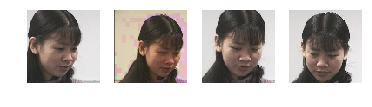

In [19]:
im_idx = 390
n_panels = 4
for i in range(n_panels):
    i0 = i + im_idx
    plt.subplot(1,n_panels,i+1)
    im_temp = trn_im[i0,:,:,:]
    im_temp = np.transpose(im_temp, (1,2,0))
    ## BGR -> RGB 
    plt.imshow(im_temp[:,:,[2,1,0]])
    plt.axis('off')

## Train the model
### Make iterators from nparrays

In [20]:
batch_size = 300

trn_iter_grid = mx.io.NDArrayIter((trn_im.astype(np.float32)) * 255, np_trn_grid_cls, batch_size, shuffle=True)
test_iter_grid = mx.io.NDArrayIter((test_im.astype(np.float32)) * 255, np_test_grid_cls, batch_size)

In [21]:
print(trn_iter_grid.provide_data[0], trn_iter_grid.provide_label[0])

(DataDesc[data,(300, 3L, 84L, 84L),<type 'numpy.float32'>,NCHW], DataDesc[softmax_label,(300,),<type 'numpy.float32'>,NCHW])


## Training 
### Modify the ResNet 50 model from model zoo 

The number of output classes is modified to 9 to match our data.

In [22]:
(new_sym, new_args) = change_num_output(sym, arg_params, num_classes = max(np_trn_grid_cls) + 1)
shape = {"data": (batch_size, trn_im.shape[1], trn_im.shape[2], trn_im.shape[3])}

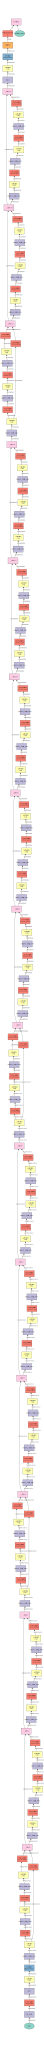

In [23]:
mx.viz.plot_network(new_sym, shape=shape)

### Fine-tune the model

We run the training. 

In [24]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

# p2.8 instance has 8 GPUs. 
ctx = [mx.gpu(i) for i in range(6)] 
#ctx = mx.cpu()
num_epoch = 5

net = mx.mod.Module(symbol=new_sym, context=ctx)
net.bind(data_shapes=[trn_iter_grid.provide_data[0]], label_shapes=[trn_iter_grid.provide_label[0]])

### Checkpoint
model_prefix = 'chkpt_Res50_1_3x3'
checkpoint = mx.callback.do_checkpoint(model_prefix, 1)

### EvalCallback
model_prefix_best = 'chkpt_best_Res50_1_3x3'
ev_cb = EvalCallback(model_prefix_best, "accuracy", "max", save_model=True)

net.fit(trn_iter_grid,
       test_iter_grid,
       arg_params=new_args, ### Fine Tune 
       aux_params=aux_params, ### Fine Tune
       initializer=mx.init.Xavier(rnd_type='gaussian', factor_type="in", magnitude=2), ### Fine Tune
       allow_missing=True, ### Fine Tune 
       optimizer="adam",
       optimizer_params={'learning_rate' : 0.0005},
       eval_metric='acc',
       batch_end_callback=mx.callback.Speedometer(batch_size, 100),
       epoch_end_callback=checkpoint,
       eval_batch_end_callback=ev_cb, ##
       num_epoch=num_epoch
       )

INFO:root:Epoch[0] Batch [100]	Speed: 314.94 samples/sec	accuracy=0.844554
INFO:root:Epoch[0] Batch [200]	Speed: 312.73 samples/sec	accuracy=0.932467
INFO:root:Epoch[0] Train-accuracy=0.936812
INFO:root:Epoch[0] Time cost=214.388
INFO:root:Saved checkpoint to "chkpt_Res50_1_3x3-0001.params"
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "chkpt_best_Res50_1_3x3-0000.params"


The best model found so far at epoch 00000 with accuracy 0.823333333333


INFO:root:Saving the Model
INFO:root:Saved checkpoint to "chkpt_best_Res50_1_3x3-0000.params"


The best model found so far at epoch 00000 with accuracy 0.826666666667


INFO:root:Epoch[0] Validation-accuracy=0.807778
INFO:root:Epoch[1] Batch [100]	Speed: 312.65 samples/sec	accuracy=0.959472
INFO:root:Epoch[1] Batch [200]	Speed: 312.64 samples/sec	accuracy=0.964700
INFO:root:Epoch[1] Train-accuracy=0.967246
INFO:root:Epoch[1] Time cost=214.357
INFO:root:Saved checkpoint to "chkpt_Res50_1_3x3-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.774444
INFO:root:Epoch[2] Batch [100]	Speed: 312.65 samples/sec	accuracy=0.973828
INFO:root:Epoch[2] Batch [200]	Speed: 312.58 samples/sec	accuracy=0.983000
INFO:root:Epoch[2] Train-accuracy=0.982029
INFO:root:Epoch[2] Time cost=214.377
INFO:root:Saved checkpoint to "chkpt_Res50_1_3x3-0003.params"
INFO:root:Epoch[2] Validation-accuracy=0.748333
INFO:root:Epoch[3] Batch [100]	Speed: 312.64 samples/sec	accuracy=0.982475
INFO:root:Epoch[3] Batch [200]	Speed: 312.67 samples/sec	accuracy=0.985133
INFO:root:Epoch[3] Train-accuracy=0.982174
INFO:root:Epoch[3] Time cost=214.360
INFO:root:Saved checkpoint to "chkpt_Res50

### Learning Curve

The plot shows the changes in validation accuracy during the trining. 

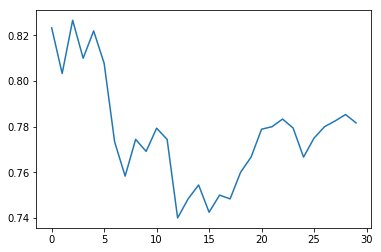

In [25]:
val_metrics = ev_cb.get_loss_metrics()
plt.plot(val_metrics)

## Take a peek at validation results

Let's load a model and make inference results of validation data.  

In [26]:
model_symbol = model_prefix + "-symbol.json"
model_params = model_prefix + "-0005.params" 

sym, arg_params, aux_params = load_model(model_symbol, model_params)

#ctx = mx.cpu() # USE CPU to look up validation results 
ctx = [mx.gpu(i) for i in range(4)] # USE GPU to look up validation results 
net2 = mx.mod.Module(symbol=sym,context=ctx)
net2.bind(data_shapes=[trn_iter_grid.provide_data[0]], label_shapes=[trn_iter_grid.provide_label[0]])
net2.set_params(arg_params, aux_params)

### Infer validation data iterator

In [27]:
preds = net2.predict(test_iter_grid).asnumpy()
print(preds.shape)
### Head Pose Prediction (9 classes)
pred_cls = []

for idx in range(preds.shape[0]):
    pred_cls += [int(preds[idx].argmax())]

### Tilt Prediction (3 classes)
pred_tilt = pred_cls % max(np_trn_tilt_cls + 1)
### Pan Prediction (3 classes)
pred_pan = pred_cls // max(np_trn_tilt_cls + 1) 

(1674, 9)


## Confusion matrix

Confusion matrix is one of the useful ways to visualize the validation accuracy. 

In [28]:
from sklearn.metrics import confusion_matrix

lst_angl_lbl = ['<< -19.5 dgrs', '-19.5 to 19.5 dgrs', '>> 19.5 dgrs']
lst_angl_lbl_tilt = ['<< -19.5 dgrs (Down)', '-19.5 to 19.5 dgrs', '>> 19.5 dgrs (Up)']
lst_angl_lbl_pan = ['<< -19.5 dgrs (Your Right)', '-19.5 to 19.5 dgrs', '>> 19.5 dgrs (Your Left)']

cm_grid = confusion_matrix(y_true=np_test_grid_cls,  # True class for test-set.
                      y_pred=pred_cls)  # Predicted class.

cm_tilt = confusion_matrix(y_true=np_test_tilt_cls,  # True class for test-set.
                      y_pred=pred_tilt)  # Predicted class.

cm_pan = confusion_matrix(y_true=np_test_pan_cls,  # True class for test-set.
                      y_pred=pred_pan)  # Predicted class.

### Confusion matrix helper function

In [29]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Head pose prediction in the 9 classes
### Confusion matrix

Confusion matrix, without normalization
[[142  28   0  10   0   0   0   0   0]
 [  4 207  56   0   3   0   0   0   0]
 [  0   5 174   0   0   1   0   0   0]
 [  0   0   0 113  10   0   3   0   0]
 [  0   2   2  10 114  22   0   9   3]
 [  0   0  13   0  18  71   0   0  24]
 [  0   0   0  11   0   0 144  25   0]
 [  0   0   0   0   2   0  32 188  48]
 [  0   0   0   0   0   0   0  13 167]]


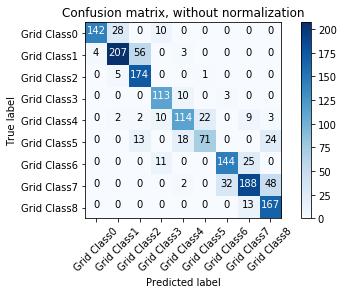

In [30]:
# Compute confusion matrix Head Pose 
cnf_matrix = cm_grid
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Grid Class" + str(i) for i in range(max(np_trn_grid_cls + 1))],
                      title='Confusion matrix, without normalization')

plt.rc('figure', figsize=(10.0, 5.0))

### Normalized confusion matrix

Normalized confusion matrix
[[ 0.79  0.16  0.    0.06  0.    0.    0.    0.    0.  ]
 [ 0.01  0.77  0.21  0.    0.01  0.    0.    0.    0.  ]
 [ 0.    0.03  0.97  0.    0.    0.01  0.    0.    0.  ]
 [ 0.    0.    0.    0.9   0.08  0.    0.02  0.    0.  ]
 [ 0.    0.01  0.01  0.06  0.7   0.14  0.    0.06  0.02]
 [ 0.    0.    0.1   0.    0.14  0.56  0.    0.    0.19]
 [ 0.    0.    0.    0.06  0.    0.    0.8   0.14  0.  ]
 [ 0.    0.    0.    0.    0.01  0.    0.12  0.7   0.18]
 [ 0.    0.    0.    0.    0.    0.    0.    0.07  0.93]]


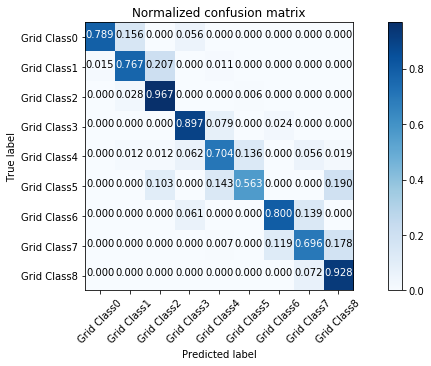

In [31]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Grid Class" + str(i) for i in range(9)], normalize=True,
                      title='Normalized confusion matrix')

plt.rc('figure', figsize=(10.0, 5.0))

## Head pose prediction in Tilt (Pitch)

Confusion matrix, without normalization
[[423  63   0]
 [ 46 525 131]
 [  0  36 450]]
Normalized confusion matrix
[[ 0.87   0.13   0.   ]
 [ 0.066  0.748  0.187]
 [ 0.     0.074  0.926]]


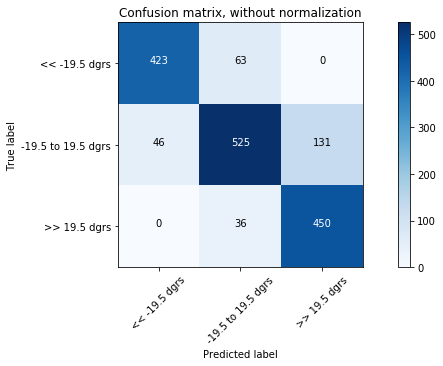

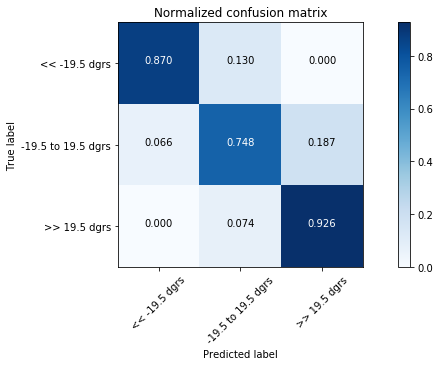

In [32]:
# Compute confusion matrix Tilt (Pitch)
cnf_matrix = cm_tilt
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lst_angl_lbl,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lst_angl_lbl, normalize=True,
                      title='Normalized confusion matrix')

plt.rc('figure', figsize=(5.0, 4.0))

## Head pose prediction in Pan (Yaw)

Confusion matrix, without normalization
[[616  14   0]
 [ 17 358  39]
 [  0  13 617]]
Normalized confusion matrix
[[ 0.978  0.022  0.   ]
 [ 0.041  0.865  0.094]
 [ 0.     0.021  0.979]]


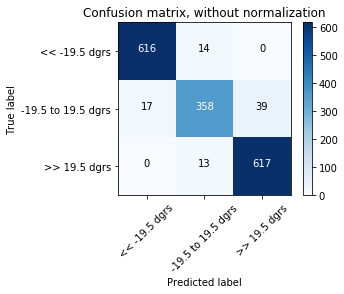

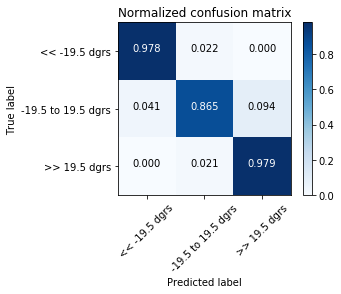

In [33]:
# Compute confusion matrix Pan (Yaw)
cnf_matrix = cm_pan
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lst_angl_lbl,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lst_angl_lbl, normalize=True,
                      title='Normalized confusion matrix')

plt.rc('figure', figsize=(5.0, 4.0))

## Prediction accuracy

In [34]:
i_test_count = 0

for idx in range(np_test_tilt_cls.shape[0]):
    if abs(np_test_tilt_cls[idx] - pred_tilt[idx]) + abs(np_test_pan_cls[idx] - pred_pan[idx]) >= 1:
        i_test_count += 1

print("The number of false predictions: {}".format(i_test_count))
print("Validation Accuracy: {:.3f}".format(1 - float(i_test_count)/np_test_tilt_cls.shape[0]))

The number of false predictions: 354
Validation Accuracy: 0.789


## Inference

### Predict a head pose of an arbitrary image

In [35]:
sym, arg_params, aux_params = load_model(model_symbol, model_params)
dshape = [('data', (1,trn_im.shape[1], trn_im.shape[2], trn_im.shape[3]))]

ctx = mx.cpu() # USE CPU to predict... 
net2 = mx.mod.Module(symbol=sym,context=ctx)
net2.bind(for_training=False, data_shapes=dshape)
net2.set_params(arg_params, aux_params)

/home/ubuntu/src/mxnet/python/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


### Load, crop, and resize a head image 

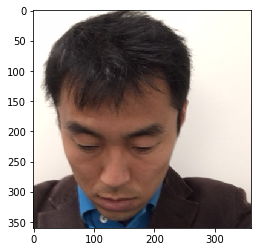

(360, 360, 3)


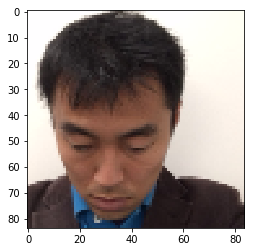

(84, 84, 3)


In [36]:
###
im = cv2.imread("testIMs/" + "IMG_1247.JPG")
im_true = im.copy()

if trn_im.shape[2] == trn_im.shape[3]:
    ### Aspect Ratio 1:1
    crop_uly = 62
    crop_height = 360
    crop_ulx = 100
    crop_width = 360
    im = im[crop_uly:crop_uly + crop_height, crop_ulx:crop_ulx + crop_width]
    im_crop = im.copy()
    plt.imshow(im_crop[:,:,::-1])
    plt.show()
    print(im.shape)

    im = cv2.resize(im, (trn_im.shape[3], trn_im.shape[2]))
    plt.imshow(im[:,:,::-1])
    plt.show()
    print(im.shape)
else:
    ### Aspect Ratio 16:9
    crop_uly = 62
    crop_height = 360
    crop_ulx = 0
    crop_width = 640
    im = im[crop_uly:crop_uly + crop_height, crop_ulx:crop_ulx + crop_width]
    im_crop = im.copy()
    plt.imshow(im_crop[:,:,::-1])
    plt.show()
    print(im.shape)

    im = cv2.resize(im, (trn_im.shape[3], trn_im.shape[2]))
    plt.imshow(im[:,:,::-1])
    plt.show()
    print(im.shape)
    
im = np.swapaxes(im, 0, 2)
im = np.swapaxes(im, 1, 2)
im = im[np.newaxis, :]

In [37]:
print(im.shape)

(1, 3, 84, 84)


### Predict a head pose

In [38]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])
net2.forward(Batch([mx.nd.array(im)]))
prob = net2.get_outputs()[0].asnumpy()
pred = prob.argmax()
print(prob)
print("Predicted Class: {}, {:.1f}%".format(pred, prob[0][pred] * 100))

[[  1.067e-04   1.848e-06   4.576e-06   9.997e-01   9.798e-05   2.742e-05
    6.086e-05   5.204e-06   4.315e-05]]
Predicted Class: 3, 100.0%


### Display a head pose

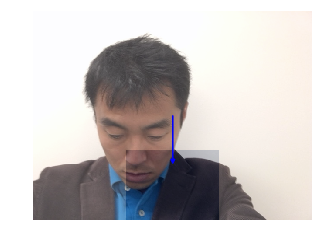

In [39]:
n_grid_cls = 9
n_tilt_cls = 3

### Tilt Prediction
pred_tilt_pic = pred % n_tilt_cls
### Pan Prediction
pred_pan_pic = pred // n_tilt_cls

extent = 0, im_true.shape[1]-1, im_true.shape[0]-1, 0
Panel_Pred = np.zeros((n_tilt_cls, n_tilt_cls))
Panel_Pred[pred_tilt_pic, pred_pan_pic] = 1
Panel_Pred = np.fliplr(Panel_Pred)
Panel_Pred = np.flipud(Panel_Pred)
plt.imshow(im_true[:,:,[2,1,0]], extent=extent)
plt.imshow(Panel_Pred, cmap=plt.cm.Blues, alpha=.2, interpolation='nearest', extent=extent)
plt.axis('off')
arrw_mg = 100
arrw_x_rad = 1 * (prob[0][0] + prob[0][1] + prob[0][2] - prob[0][6] -prob[0][7] - prob[0][8]) * 90 * np.pi / 180. 
arrw_y_rad = 1 * (prob[0][0] + prob[0][3] + prob[0][6] - prob[0][2] -prob[0][5] - prob[0][8]) * 90 * np.pi / 180.
plt.arrow(im_true.shape[1]//2, im_true.shape[0]//2, 
          np.sin(arrw_x_rad) * arrw_mg, np.sin(arrw_y_rad) * arrw_mg, 
          head_width=10, head_length=10, fc='b', ec='b')
plt.show()

## End